In [1]:
!pip install pandas
!pip install requests
!pip install matplotlib

You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
import os
from typing import Set, Any, Optional, Union

import requests
import pandas as pd
import matplotlib.pyplot as plt


class Reader:
    """
        This class imports the file, being able to distinguish between different file types (csv, excel).

        ...

        Attributes
        ----------
        file_name : str
            name of the input file
        file_type : str
            type of the input file, got with the _get_type() method
        date_col : str
            name of the date column
        pattern_date : str
            shows how to parse the date column. For example: '%Y-%m-%d'

        Methods
        -------
        read_file()
            Imports the file with a function according to the file type.
    """

    def __init__(self, file_name: str, date_col: str, pattern_date: str):
        self.file_name = file_name
        self.file_type = self._get_type()
        self.date_col = date_col
        self.pattern_date = pattern_date

    def _get_type(self) -> str:
        # This method extracts the file type from the file name
        _, file_extension = os.path.splitext(self.file_name)
        return file_extension

    def read_file(self) -> pd.DataFrame:
        reader = self._get_reader()
        return reader()

    def _get_reader(self):
        # This method calls a specific reader according to the file type.
        if self.file_type == '.csv':
            return self._csv_reader
        elif self.file_type == '.xlsx':
            return self._xlsx_reader
        else:
            raise ValueError(self.file_type)

    def _csv_reader(self) -> pd.DataFrame:
        # This method implements a reader specific to .csv file type, using a function from the pandas library.
        data_frame = pd.read_csv(self.file_name,
                                 parse_dates=[self.date_col],
                                 date_parser=lambda x: pd.datetime.strptime(x, pattern_date_parse),
                                 sep=',',
                                 header=0)
        return data_frame

    def _xlsx_reader(self):
        # Should implement a reader specific to .xlsx file type, (probably) using a function from the pandas library.
        raise Exception("This method is not defined yet!")


class MyDataFrame:
    """
        This class holds the data read from the input file, and all data produced from it afterwards;
        also it has methods that fulfill the transformation and saving operation on the data.

        ...

        Attributes
        ----------
        data : Reader
            initialized instance of the Reader class defined above
        df : pd.DataFrame
            data from the file turned to a DataFrame object
        cols_stats : List
            Created as empty, afterwards holds the column names, for which statistics is calculated.
        min : List
            Created as empty, afterwards holds the minimum values for the required columns.
        max : List
            Created as empty, afterwards holds the maximum values for the required columns.
        mean : List
            Created as empty, afterwards holds the average values for the required columns.

        Methods
        -------
        filter_days()
            Leaves only the last n required days in the dataset. The number n is an argument.
        leave_columns()
            leaves only required columns; the list of columns is an argument.
        convert_currency()
            Multiplies the values from a specified column with a given factor to get values for another currency.
            Currently: USD -> EUR
        create_stats()
            Calculated the min, max and mean values for the specified columns and saves them in 3 respective lists.
            These lists are attributes of the class instance.
        print_stats()
            Prints the 3 statistics lists together with respective column names in a data frame format to the stdout.
        export_file()
            Saves the transformed data (data from the file after filtering columns, dates and calculating financial data
            in new currency) in a csv file.
    """

    def __init__(self, data):
        self.data = data
        self.df = self.data.read_file()
        self.cols_stats = []
        self.min = []
        self.max = []
        self.mean = []

    def filter_days(self, days_range: int):
        self.df = self.df[self.df.date.isin(pd.date_range(
            pd.Timedelta(-days_range + 1, unit='d') + self.df[self.data.date_col].max(), periods=days_range))]
        self.df = self.df.reset_index(drop=True)

    def leave_columns(self, required_cols: Set[Any]):  # надо ли тут вообще???
        all_cols: Set[Any] = set(self.df.columns)
        diff: Set[Any] = all_cols - required_cols
        self.df.drop(diff, axis=1, inplace=True)

    def convert_currency(self, cols_dict: dict, exc_rate: float):
        for k, v in cols_dict.items():
            self.df[k] = self.df[v] * exc_rate

    def create_stats(self, col_name: str, conversion_value: Optional[Union[float, int]] = None):
        if conversion_value is None:
            conversion_value = 1
        self.cols_stats.append(col_name)

        self.min.append(format(self.df[col_name].min() / conversion_value, '.2f'))
        self.max.append(format(self.df[col_name].max() / conversion_value, '.2f'))
        self.mean.append(format(self.df[col_name].mean() / conversion_value, '.2f'))

    def print_stats(self):
        stats = pd.DataFrame({'attr': self.cols_stats,
                              'min': self.min,
                              'max': self.max,
                              'average': self.mean})
        stats.set_index('attr', inplace=True)
        print(stats)

    def export_file(self, file_name_export: str):
        self.df.to_csv(file_name_export,
                       sep=',',
                       index=False)


# ########################## CONFIG ############################
file_name = 'btc-1.csv'
file_name_export = 'btc-last-year.csv'

date_col = 'date'
pattern_date_parse = '%Y-%m-%d'
col_date = 'date'
col_market_cap_usd = 'marketcap(USD)'
col_price_usd = 'price(USD)'
col_gen_coins = 'generatedCoins'
col_paym_count = 'paymentCount'
col_market_cap_eur = 'marketcap(EUR)'
col_price_eur = 'price(EUR)'
required_cols = {col_date, col_market_cap_usd, col_price_usd, col_gen_coins, col_paym_count}

DEFAULT_EXC_RATE = 0.87
days_range = 365

# This dict holds the columns, for which statistics is needed, and values for conversion of financial data
# e.g. to billions of EUR.
cols_to_print = {col_market_cap_eur: 1000000000,
                 col_price_eur: None,
                 col_gen_coins: None,
                 col_paym_count: None}

# ##############################################################


df = MyDataFrame(Reader(file_name, date_col, pattern_date_parse))
df.filter_days(days_range)
df.leave_columns(required_cols)

try:
    r = requests.get("http://exc_rate_getter:5000/", timeout=3)  # value of 3 seconds can be adjusted.
    print("Got the actual currency exchange rate from remote service.")
    exc_rate = float(r.content)
# Exceptions added, if a connections lasts for more than allowed
except (requests.exceptions.Timeout,
        requests.exceptions.ReadTimeout,
        requests.exceptions.ConnectTimeout,
        requests.exceptions.ConnectionError) as e:
    print("Currency exchange rate set to default")
    exc_rate = DEFAULT_EXC_RATE

df.convert_currency({col_market_cap_eur: col_market_cap_usd, col_price_eur: col_price_usd}, exc_rate)
df.export_file(file_name_export)

print('Sum of generatedCoins: ',
      df.df[col_gen_coins].sum())

for k, v in cols_to_print.items():
    df.create_stats(k, v)
df.print_stats()

Currency exchange rate set to default
Sum of generatedCoins:  701356.24967671
                      min        max    average
attr                                           
marketcap(EUR)      61.10     283.74     127.60
price(EUR)        3680.00   16943.95    7538.25
generatedCoins    1000.00    2437.50    1921.52
paymentCount    238637.00  808680.00  401912.66


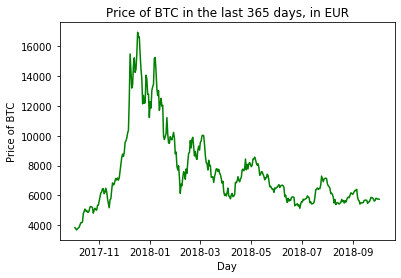

In [6]:
# ######################## CREATE A PLOT ############################
# The following steps create a line graph for the price of BTC.
plt.plot(df.df[date_col], df.df[col_price_eur], color='green')
plt.xlabel('Day')
plt.ylabel('Price of BTC')
plt.title('Price of BTC in the last 365 days, in EUR')
plt.show()